In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Dense, Input, AveragePooling2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, UpSampling2D, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [2]:
all_images_df = pd.read_csv('defect_and_no_defect.csv')

In [3]:
all_images_df.shape

(12997, 2)

In [5]:
all_images_df

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1
...,...,...
12992,0482ee1d6.jpg,0
12993,04802a6c2.jpg,0
12994,03ae2bc91.jpg,0
12995,04238d7e3.jpg,0


ImagemID mostra apenas o link das imagem

In [29]:
defect_class_mask_df = pd.read_csv('train.csv')

In [7]:
defect_class_mask_df.shape

(5748, 3)

In [33]:
print("A porcentagem das imagens que apresentam defeito é %.2f." %(defect_class_mask_df.shape[0] * 100 / all_images_df.shape[0]))

A porcentagem das imagens que apresentam defeito é 44.23.


In [34]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...
...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...


In [35]:
defect_class_mask_df.ClassId.unique()

array([1, 3, 4, 2], dtype=int64)

# Exploração de dados

In [36]:
all_images_df.label.value_counts()

1    7095
0    5902
Name: label, dtype: int64

Text(0.5, 1.0, 'Defeitos e não defeitos')

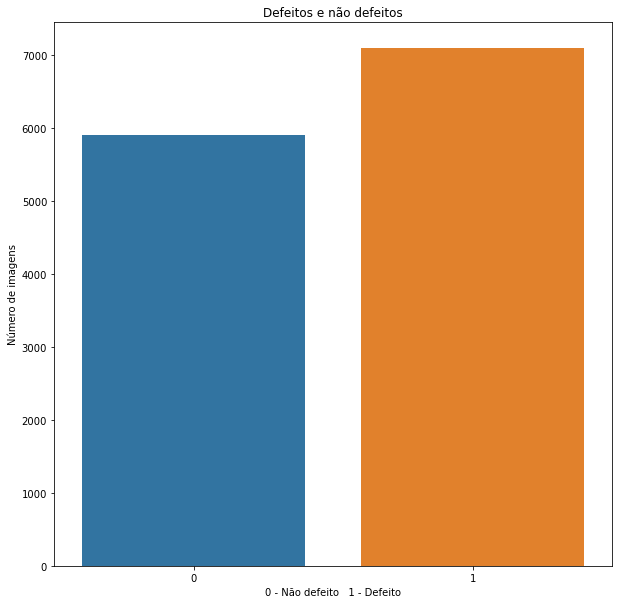

In [38]:
plt.figure(figsize = (10, 10))
sns.barplot(x = all_images_df.label.value_counts().index, y = all_images_df.label.value_counts())
plt.ylabel('Número de imagens')
plt.xlabel('0 - Não defeito   1 - Defeito')
plt.title('Defeitos e não defeitos')

Text(0.5, 1.0, 'Número de imagens por classe de defeito')

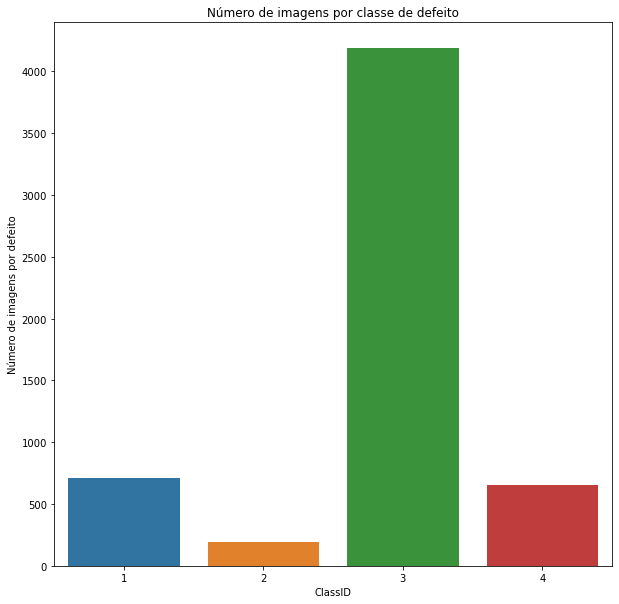

In [40]:
plt.figure(figsize = (10, 10))
sns.countplot(x = defect_class_mask_df.ClassId)
plt.ylabel('Número de imagens por defeito')
plt.xlabel('ClassID')
plt.title('Número de imagens por classe de defeito')

In [31]:
defect_class_mask_df['mask'] = defect_class_mask_df.ClassId.map(lambda x: 1)

In [42]:
defect_class_mask_df.head()

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1


In [43]:
defect_type = defect_class_mask_df.groupby(['ImageId'])['mask'].sum()

In [44]:
defect_type

ImageId
0002cc93b.jpg    1
0007a71bf.jpg    1
000a4bcdd.jpg    1
000f6bf48.jpg    1
0014fce06.jpg    1
                ..
ffcf72ecf.jpg    1
fff02e9c5.jpg    1
fffe98443.jpg    1
ffff4eaa8.jpg    1
ffffd67df.jpg    1
Name: mask, Length: 5474, dtype: int64

Text(0.5, 1.0, 'Número de defeitos nas imagens')

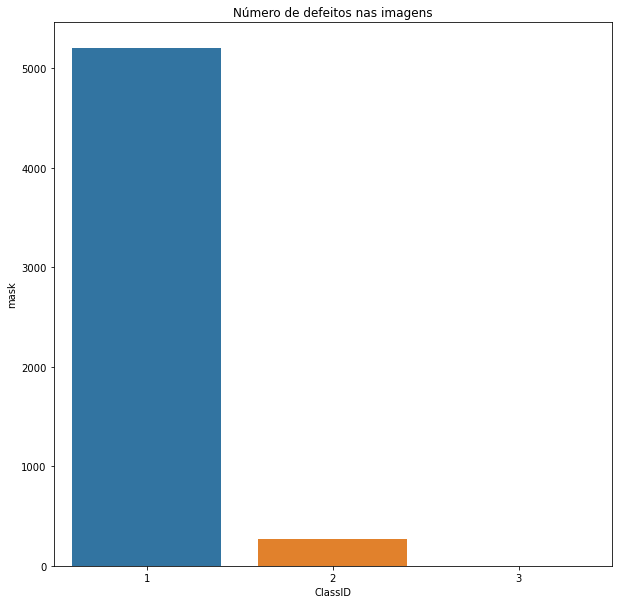

In [46]:
plt.figure(figsize = (10, 10))
sns.barplot(x = defect_type.value_counts().index, y = defect_type.value_counts())
plt.xlabel('ClassID')
plt.title('Número de defeitos nas imagens')

In [14]:
train_dir = 'train_images/'

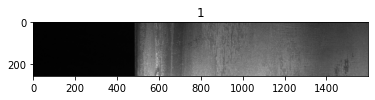

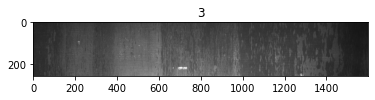

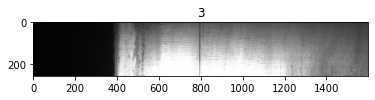

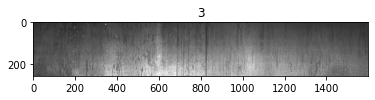

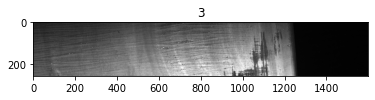

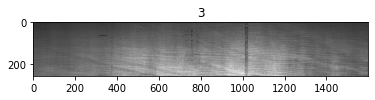

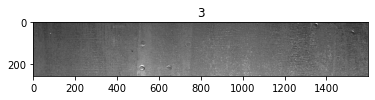

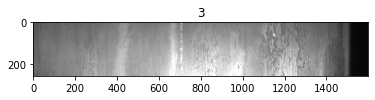

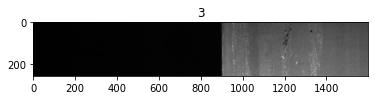

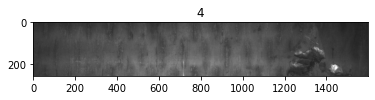

In [49]:
for i in range(10):
    img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
    plt.figure()
    plt.title(defect_class_mask_df.ClassId[i])
    plt.imshow(img)

In [78]:
from utilities import rle2mask

In [53]:
mask = rle2mask(defect_class_mask_df.EncodedPixels[20], img.shape[0], img.shape[1])

In [54]:
mask.shape

(256, 1600)

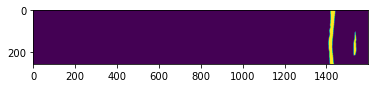

In [55]:
plt.imshow(mask)

(256, 1600, 3)

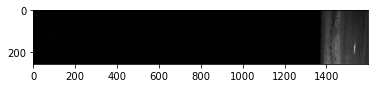

In [56]:
img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[20]))
plt.imshow(img)
img.shape

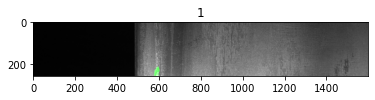

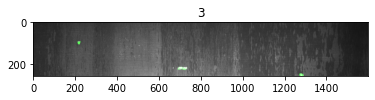

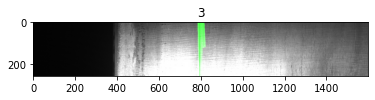

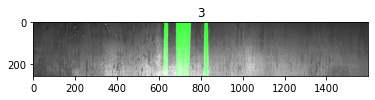

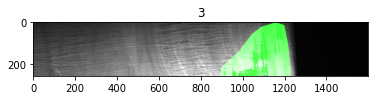

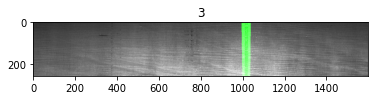

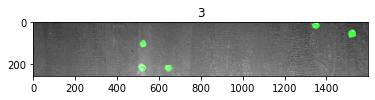

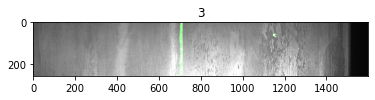

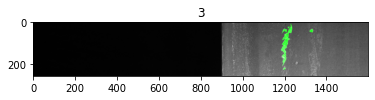

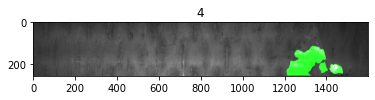

In [57]:
for i in range(10):
    img = io.imread(os.path.join(train_dir, defect_class_mask_df.ImageId[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(defect_class_mask_df.EncodedPixels[i], img.shape[0], img.shape[1])
    
    img[mask == 1,1] = 255
    plt.figure()
    plt.title(defect_class_mask_df.ClassId[i])
    plt.imshow(img)

# Rede Neural para prever defeito em uma imagem

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(all_images_df, test_size = 0.15)

In [9]:
train.shape, test.shape

((11047, 2), (1950, 2))

In [10]:
print(train.head(), '\n\n', test.head())

             ImageID  label
4620   a81d409c6.jpg      1
8705   b8c07feb2.jpg      0
3384   7b547b234.jpg      1
12351  1a4ac4d43.jpg      0
4111   9570a27f4.jpg      1 

              ImageID  label
9731   888263bf8.jpg      0
4635   a8bc0275d.jpg      1
5559   c828ece4b.jpg      1
12953  005b92582.jpg      0
8560   c3a805375.jpg      0


In [11]:
from keras_preprocessing.image import ImageDataGenerator

In [12]:
datagen = ImageDataGenerator(rescale = 1. / 255, validation_split = 0.15)

In [15]:
train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_dir,
    x_col = 'ImageID',
    y_col = 'label',
    subset = 'training',
    batch_size = 16,
    shuffle = True,
    class_mode = 'other',
    target_size = (256, 256)
)

Found 9390 validated image filenames.


C:\Users\breve\anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="ImageID". These filename(s) will be ignored.
  warnings.warn(


In [16]:
valid_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_dir,
    x_col = 'ImageID',
    y_col = 'label',
    subset = 'validation',
    batch_size = 16,
    shuffle = True,
    class_mode = 'other',
    target_size = (256, 256)
)

Found 1656 validated image filenames.


In [17]:
test_datagen = ImageDataGenerator(rescale = 1. / 255.)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = train_dir,
    x_col = 'ImageID',
    y_col = None,
    batch_size = 16,
    shuffle = False,
    class_mode = None,
    target_size = (256, 256)
)

Found 1950 validated image filenames.


In [78]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

In [79]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

conv4_block4_1_conv (Conv2D)    (None, 16, 16, 256)  262400      conv4_block3_out[0][0]           
__________________________________________________________________________________________________
conv4_block4_1_bn (BatchNormali (None, 16, 16, 256)  1024        conv4_block4_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block4_1_relu (Activation (None, 16, 16, 256)  0           conv4_block4_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_2_conv (Conv2D)    (None, 16, 16, 256)  590080      conv4_block4_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block4_2_bn (BatchNormali (None, 16, 16, 256)  1024        conv4_block4_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_bloc

In [82]:
for layer in basemodel.layers:
    layers.trainable = False

In [85]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4, 4))(headmodel)
headmodel = Flatten()(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(1, activation = 'sigmoid')(headmodel)

In [87]:
model = Model(inputs = basemodel.input, outputs = headmodel)

In [88]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [89]:
model.compile(loss = 'binary_crossentropy', optimizer = 'Nadam', metrics = ['accuracy'])

In [91]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 20)

In [92]:
checkpointer = ModelCheckpoint(filepath = 'weights.hdf5', save_best_only = True)

In [96]:
history = model.fit(
    train_generator,
    epochs = 1,
    validation_data = valid_generator,
    callbacks = [checkpointer, earlystopping]
)

587/587 [==============================] - 16851s 28s/step - loss: 0.4302 - accuracy: 0.8026 - val_loss: 0.4409 - val_accuracy: 0.8068


C:\Users\breve\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [97]:
model_json = model.to_json()
with open('resnet-classifier-model-2.json', 'w') as json_file:
    json_file.write(model_json)

C:\Users\breve\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Avaliação da ResNet

In [4]:
with open('resnet-classifier-model.json', 'r') as json_file:
    json_saved_model = json_file.read()

In [5]:
json_saved_model

'{"class_name": "Functional", "config": {"name": "functional_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": true, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "name": "conv1_pad", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": true, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regula

In [6]:
model = tf.keras.models.model_from_json(json_saved_model)
model.load_weights('weights.hdf5')
model.compile(loss = 'binary_cressentropy', optimizer = 'Nadam', metrics = ['accuray'])

In [18]:
test_predict = model.predict(test_generator, verbose = True)

122/122 [==============================] - 638s 5s/step


In [19]:
test_predict

array([[1.5318394e-04],
       [9.3327528e-01],
       [6.9511372e-01],
       ...,
       [8.3891815e-01],
       [8.9977014e-01],
       [3.2652843e-01]], dtype=float32)

In [20]:
predict = []
for i in test_predict:
    if i < 0.01:
        predict.append(0)
    else:
        predict.append(1)
predict = np.asarray(predict)

In [21]:
len(predict)

1950

In [22]:
original = np.asarray(test.label)

In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(original, predict)

0.6471794871794871

In [26]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, predict)
cm

array([[ 177,  683],
       [   5, 1085]], dtype=int64)

<AxesSubplot:>

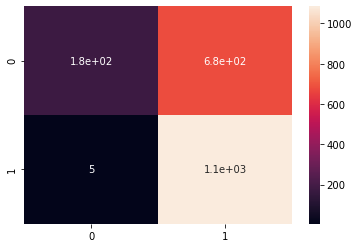

In [27]:
sns.heatmap(cm, annot = True)

In [28]:
from sklearn.metrics import classification_report
print(classification_report(original, predict))

              precision    recall  f1-score   support

           0       0.97      0.21      0.34       860
           1       0.61      1.00      0.76      1090

    accuracy                           0.65      1950
   macro avg       0.79      0.60      0.55      1950
weighted avg       0.77      0.65      0.57      1950



# Rede Neural para segmentação de imagens com ResUnet

In [32]:
defect_class_mask_df

,ImageId,ClassId,EncodedPixels,mask
0,d2291de5c.jpg,1,147963 3 148213 9 148461 18 148711 24 148965 2...,1
1,78416c3d0.jpg,3,54365 3 54621 7 54877 10 55133 12 55388 14 556...,1
2,2283f2183.jpg,3,201217 43 201473 128 201729 213 201985 5086 20...,1
3,f0dc068a8.jpg,3,159207 26 159412 77 159617 128 159822 179 1600...,1
4,00d639396.jpg,3,229356 17 229595 34 229850 36 230105 37 230360...,1
...,...,...,...,...
5743,c12842f5e.jpg,3,88 23 342 29 596 34 850 39 1105 44 1361 46 161...,1
5744,2222a03b3.jpg,3,63332 4 63587 11 63841 20 64096 27 64351 35 64...,1
5745,b43ea2c01.jpg,1,185024 7 185279 11 185535 12 185790 13 186045 ...,1
5746,1bc37a6f4.jpg,3,303867 1 304122 3 304376 6 304613 3 304630 9 3...,1


In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_val = train_test_split(defect_class_mask_df, test_size = 0.2)
X_train.shape, X_val.shape

((4598, 4), (1150, 4))

In [35]:
train_ids = list(X_train.ImageId)
train_class = list(X_train.ClassId)
train_rle = list(X_train.EncodedPixels)

In [36]:
len(train_ids), len(train_class), len(train_rle)

(4598, 4598, 4598)

In [37]:
print(train_ids[0:5])
print(train_class[0:5])
print(train_rle[0:5])

['ac03345dc.jpg', 'a831d2806.jpg', '15aeb5d52.jpg', 'c9cd221c5.jpg', '284639f13.jpg']
[3, 3, 3, 3, 1]
['297711 9 297967 9 298479 17 298735 17 298992 15 299248 15 299504 15 299760 15 300016 15 300272 14 305924 127 306180 251 306436 251 306692 252 306948 252 307330 126', '18945 4 19201 11 19457 18 19713 25 19969 32 20225 39 20481 47 20737 54 20993 61 21249 68 21505 75 21761 82 22017 89 22273 96 22529 103 22785 110 23041 117 23297 124 23553 132 23813 135 24075 136 24337 137 24600 137 24862 138 25125 138 25387 139 25649 140 25912 140 26174 141 26436 142 26699 143 26961 144 27224 144 27486 145 27748 146 28011 146 28273 144 28535 138 28798 131 29060 125 29323 118 29585 112 29847 106 30110 99 30372 93 30634 87 30897 80 31159 74 31422 67 31684 61 31946 55 32209 48 32471 42 32733 36 32996 29 33258 23 33521 16 33605 4 33783 10 33861 10 34045 4 34116 17 34372 23 34627 30 34883 36 35138 43 35394 49 35649 56 35905 62 36161 68 36416 76 36672 82 36927 89 37183 95 37438 102 37694 108 37949 115 38205 1

In [38]:
val_ids = list(X_val.ImageId)
val_class = list(X_val.ClassId)
val_rle = list(X_val.EncodedPixels)

In [39]:
len(val_ids), len(val_class), len(val_rle)

(1150, 1150, 1150)

In [59]:
from utilities import DataGenerator
training_generator = DataGenerator(train_ids, train_class, train_rle, train_dir)
validations_generator = DataGenerator(val_ids, val_class, val_rle, train_dir)

In [43]:
def resblock(X, f):
    X_copy = X
    
    X = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer = 'he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(f, kernel_size = (3,3), strides = (1,1), padding = 'same', kernel_initializer = 'he_normal')(X)
    X = BatchNormalization()(X)
    
    X_copy = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer = 'he_normal')(X)
    X_copy = BatchNormalization()(X)
    
    X = Add()([X, X_copy])
    X = Activation('relu')(X)
    
    return X

In [41]:
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])
    return merge

In [42]:
input_shape = (256, 256, 1)
X_input = Input(input_shape)

* Estágio 1

In [44]:
conv1_in = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

* Estágio 2

In [45]:
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

* Estágio 3

In [46]:
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

* Estágio 4

In [47]:
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

* Estágio 5

In [48]:
conv5_in = resblock(pool_4, 256)
pool_5 = MaxPool2D(pool_size = (2,2))(conv5_in)

* Up 1

In [49]:
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

* Up 2

In [50]:
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

* Up 3

In [51]:
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

* Up 4

In [52]:
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

* Final

In [53]:
output = Conv2D(4, (1,1), padding = 'same', activation = 'sigmoid')(up_4)
model_seg = Model(inputs = X_input, outputs = output)

# Treinamento - Focal Tversky

In [55]:
from utilities import focal_tversky, tversky_loss, tversky

In [60]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [58]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)
checkpointer = ModelCheckpoint(filepath = 'resunet-segmentation-weights-2.hdf5', verbose = 1, save_best_only = True)

In [61]:
history = model_seg.fit(training_generator,
                        epochs = 1,
                        validation_data = validations_generator,
                        callbacks = [checkpointer, earlystopping]
)

KeyboardInterrupt: 

In [63]:
model_json = model_seg.to_json()
with open('resunet-segmentation-model-2.json', 'w') as json_file:
    json_file.write(model_json)

# Avaliação ResUnet

In [67]:
with open('resunet-segmentation-model.json') as json_file:
    json_saved_model = json_file.read()

In [68]:
json_saved_model

'{"class_name": "Model", "config": {"name": "model_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 256, 256, 1], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_2"}, "name": "input_2", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "filters": 16, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 2.0, "mode": "fan_in", "distribution": "truncated_normal", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "conv2d", "inbound_nodes": [[["input_2", 0, 0, {}]]]}, {"class_name": "BatchNormalization", "config": {"name": "batc

In [69]:
model_seg = tf.keras.models.model_from_json(json_saved_model)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [70]:
test_df = pd.read_csv('test.csv')

In [71]:
test_df

,ImageId,ClassId,EncodedPixels
0,0ca915b9f.jpg,3,188383 3 188637 5 188892 6 189148 5 189403 6 1...
1,7773445b7.jpg,3,75789 33 76045 97 76300 135 76556 143 76811 15...
2,5e0744d4b.jpg,3,120323 91 120579 182 120835 181 121091 181 121...
3,6ccde604d.jpg,3,295905 32 296098 95 296290 159 296483 222 2967...
4,16aabaf79.jpg,1,352959 24 353211 28 353465 31 353719 33 353973...
...,...,...,...
633,a4334d7da.jpg,4,11829 7 12073 20 12317 32 12566 40 12821 41 13...
634,418e47222.jpg,3,46340 43 46596 127 46852 211 47108 253 47364 2...
635,817a545aa.jpg,3,206529 64 206657 4518 211201 179 211457 128 21...
636,caad490a5.jpg,3,59631 10 59867 30 60103 50 60339 69 60585 79 6...


In [72]:
from utilities import prediction

In [73]:
image_id, defect_type, mask = prediction(test_df, model, model_seg)

In [74]:
df_pred = pd.DataFrame({'ImageId': image_ididge_id, 'EncodedPixels': mask, 'ClassId': defect_type})
df_pred

,ImageId,EncodedPixels,ClassId
0,0ca915b9f.jpg,151421 1 151423 2 151677 1 151679 2 151933 1 1...,3
1,7773445b7.jpg,72927 2 73183 2 73439 2 73695 2 73951 2 74207 ...,3
2,5e0744d4b.jpg,116095 2 116351 2 116607 2 116863 2 117119 2 1...,3
3,6ccde604d.jpg,290305 4 290561 4 290817 4 291073 4 291329 4 2...,3
4,16aabaf79.jpg,352937 24 353193 24 353449 24 353705 24 353961...,3
...,...,...,...
633,a4334d7da.jpg,12076 6 12085 7 12093 2 12332 6 12341 7 12349 ...,3
634,418e47222.jpg,15359 1 15615 1 15871 1 16127 1 16383 1 16639 ...,3
635,817a545aa.jpg,202745 7 203001 7 203257 7 203513 7 203769 7 2...,3
636,caad490a5.jpg,60111 32 60367 32 60623 32 60879 32 61135 32 6...,3


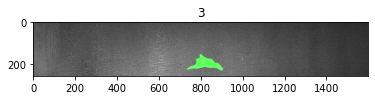

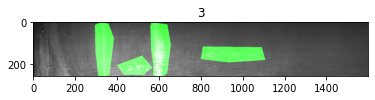

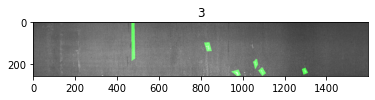

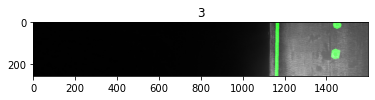

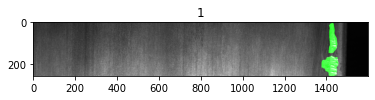

In [79]:
for i in range(5):
    img = io.imread(os.path.join(train_dir, test_df.ImageId[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(test_df.EncodedPixels[i], img.shape[0], img.shape[1])
    img[mask == 1,1] = 255
    plt.figure()
    plt.title(test_df.ClassId[i])
    plt.imshow(img)

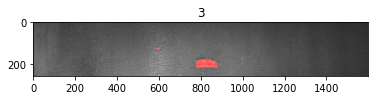

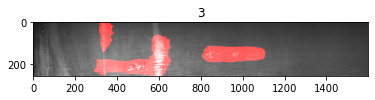

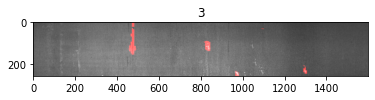

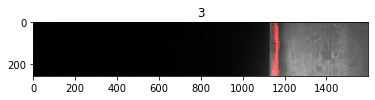

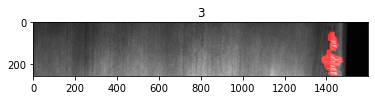

In [82]:
for i in range(5):
    img = io.imread(os.path.join(train_dir, df_pred.ImageId[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(df_pred.EncodedPixels[i], img.shape[0], img.shape[1])
    img[mask == 1,0] = 255
    plt.figure()
    plt.title(df_pred.ClassId[i])
    plt.imshow(img)